In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error

In [2]:
train_data = pd.read_csv('./zhengqi_train.txt',sep='\t',encoding='utf-8')
test_data  = pd.read_csv('./zhengqi_test.txt', sep='\t',encoding='utf-8')

In [3]:
train_data.head()

V0     V1     V2     V3     V4     V5     V6     V7     V8     V9  ...  \
0  0.566  0.016 -0.143  0.407  0.452 -0.901 -1.812 -2.360 -0.436 -2.114  ...   
1  0.968  0.437  0.066  0.566  0.194 -0.893 -1.566 -2.360  0.332 -2.114  ...   
2  1.013  0.568  0.235  0.370  0.112 -0.797 -1.367 -2.360  0.396 -2.114  ...   
3  0.733  0.368  0.283  0.165  0.599 -0.679 -1.200 -2.086  0.403 -2.114  ...   
4  0.684  0.638  0.260  0.209  0.337 -0.454 -1.073 -2.086  0.314 -2.114  ...   

     V29    V30    V31    V32    V33    V34    V35    V36    V37  target  
0  0.136  0.109 -0.615  0.327 -4.627 -4.789 -5.101 -2.608 -3.508   0.175  
1 -0.128  0.124  0.032  0.600 -0.843  0.160  0.364 -0.335 -0.730   0.676  
2 -0.009  0.361  0.277 -0.116 -0.843  0.160  0.364  0.765 -0.589   0.633  
3  0.015  0.417  0.279  0.603 -0.843 -0.065  0.364  0.333 -0.112   0.206  
4  0.183  1.078  0.328  0.418 -0.843 -0.215  0.364 -0.280 -0.028   0.384  

[5 rows x 39 columns]

##  箱型图

<AxesSubplot:xlabel='V0'>

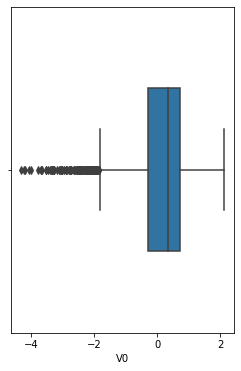

In [4]:
fig = plt.figure(figsize=(4,6))
sns.boxplot(train_data['V0'],orient='v',width=0.5)

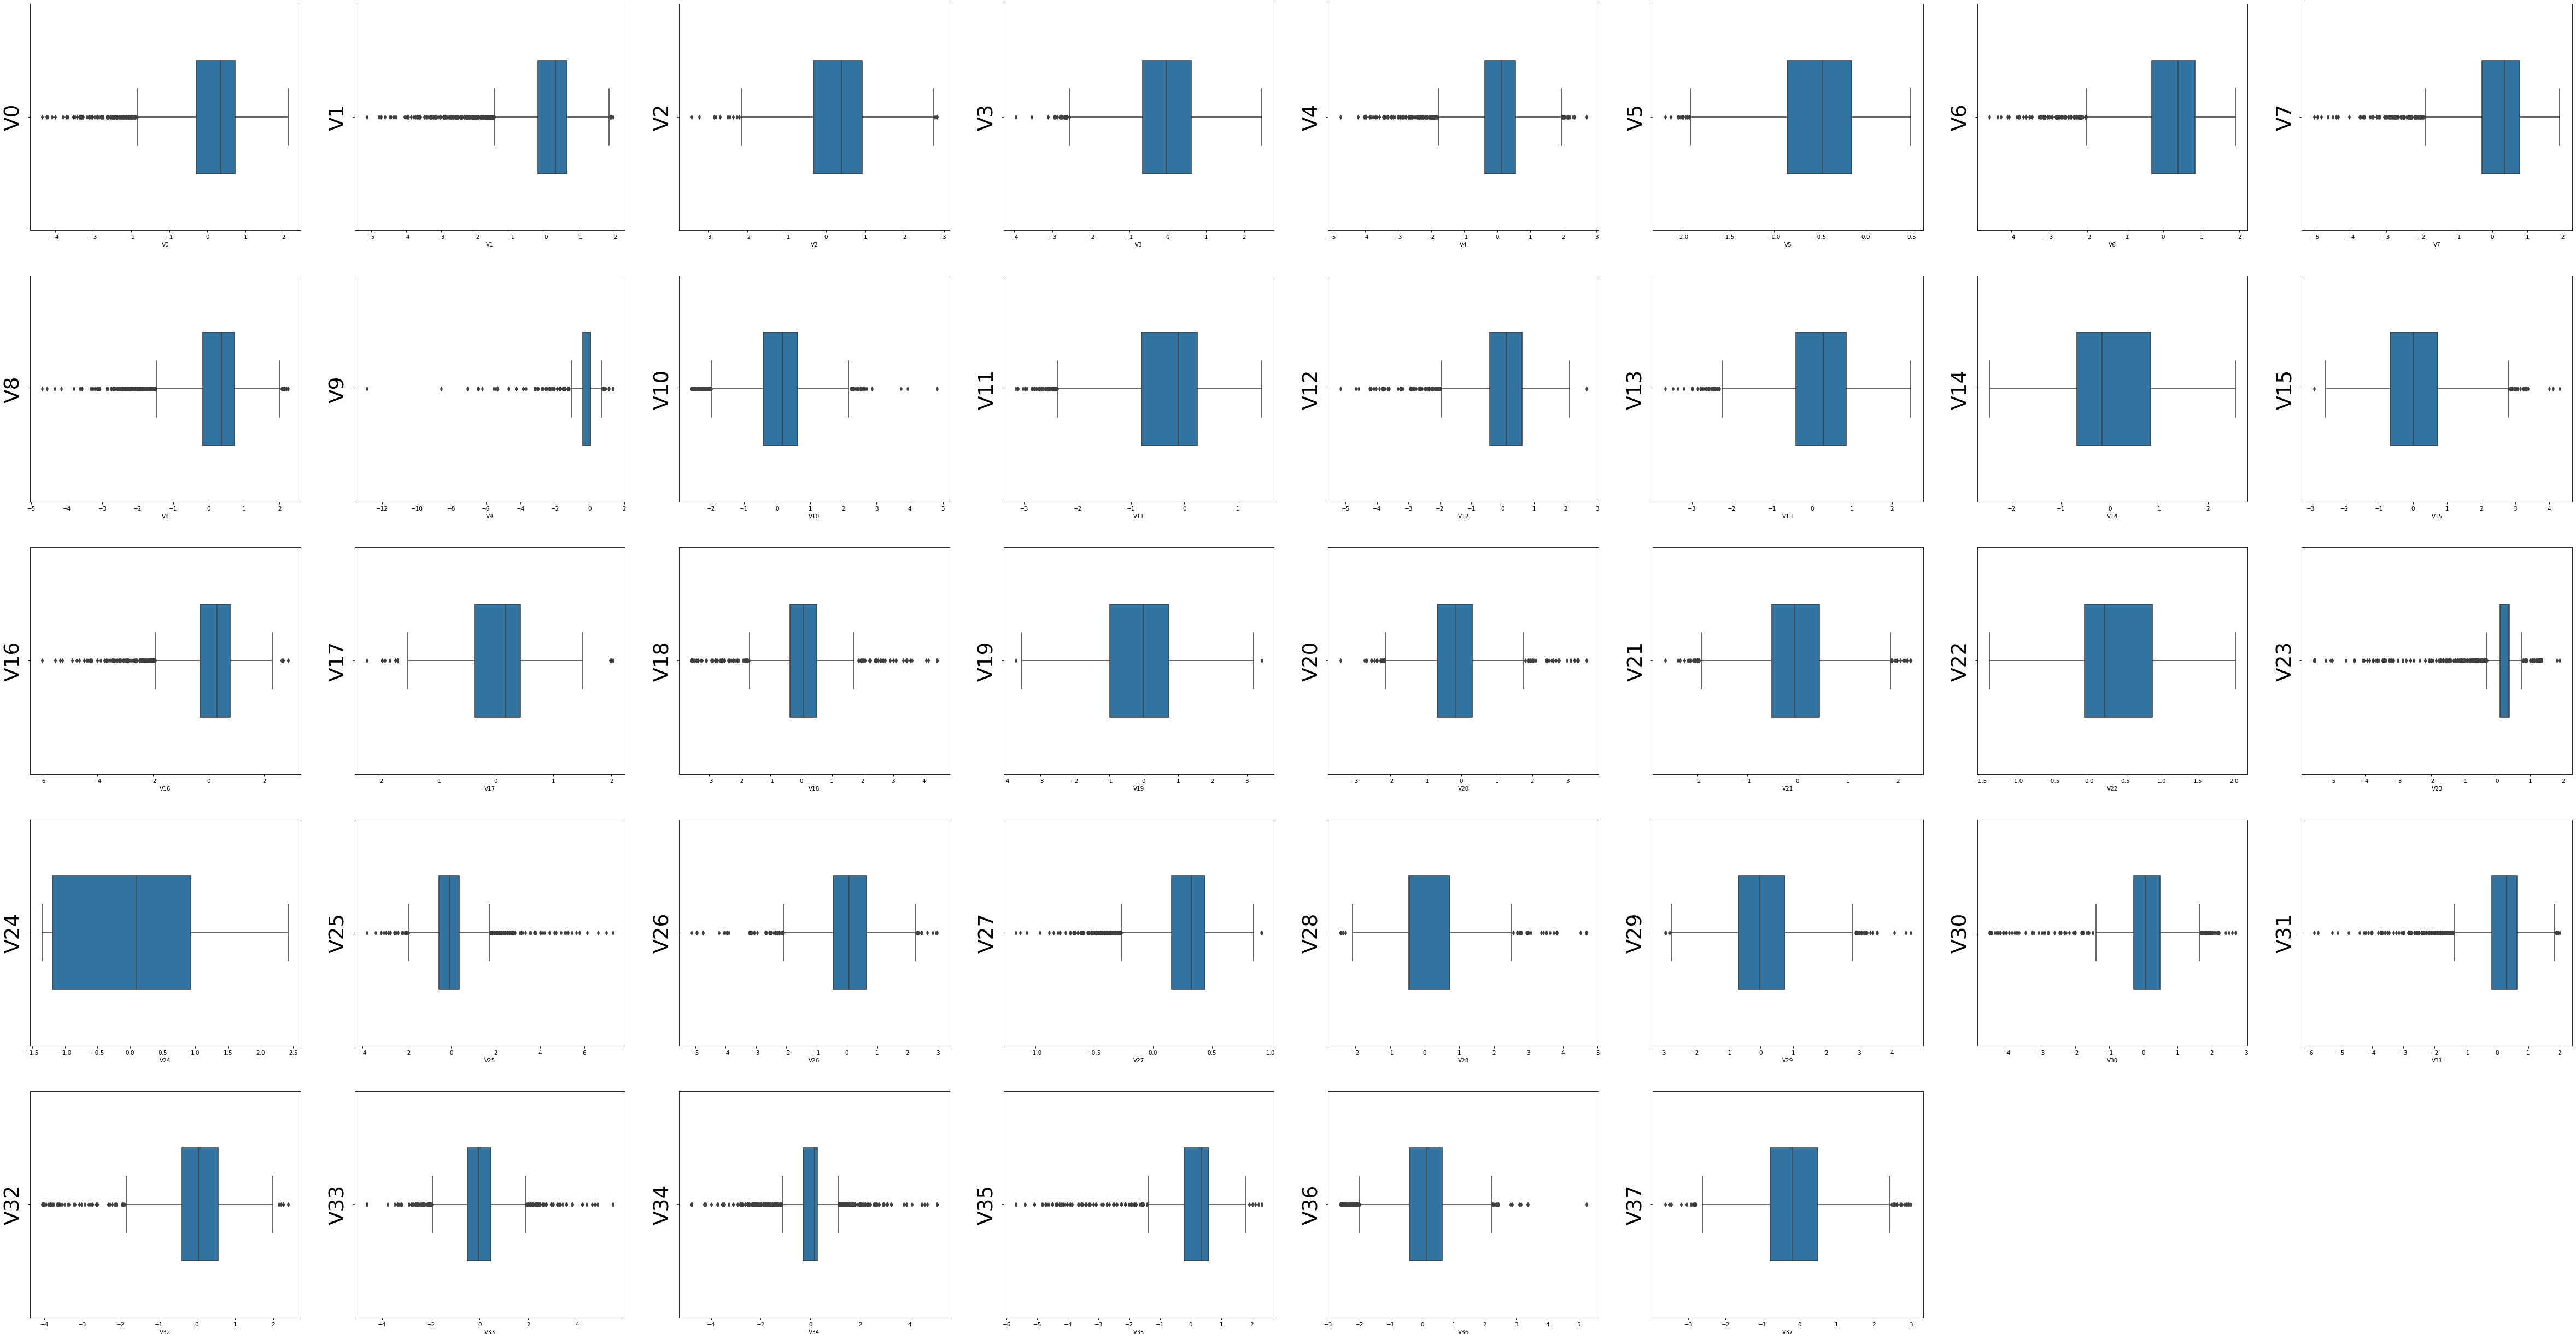

In [5]:
columns = train_data.columns.tolist()[:39]
fig = plt.figure(figsize=(80,60),dpi=75)
for i in range(38):
    plt.subplot(7,8,i+1)
    sns.boxplot(train_data[columns[i]],orient='v',width=0.5)
    plt.ylabel(columns[i],fontsize=36)
plt.show()

##  获取异常数据的函数

In [8]:
def find_outliers(model,X,y,sigma=3):
    
    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X),index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X),index=y.index)
    
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid  = resid.std()
    
    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid-mean_resid)/std_resid
    outliers = z[abs(z)>sigma].index
    
    # print and plot the results
    print('R2=',model.score(X,y))
    print('Mse=',mean_squared_error(y,y_pred))
    print('-------------------------------------------------------')
    
    print(len(outliers),'outliers;',' ALL data shape:',X.shape)
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');
    
    ax_132 = plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    
    ax_133 = plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    
    plt.savefig('outliers.png')
    
    return outliers

R2= 0.8890858938210386
Mse= 0.10734857773123635
-------------------------------------------------------
31 outliers;  ALL data shape: (2888, 38)


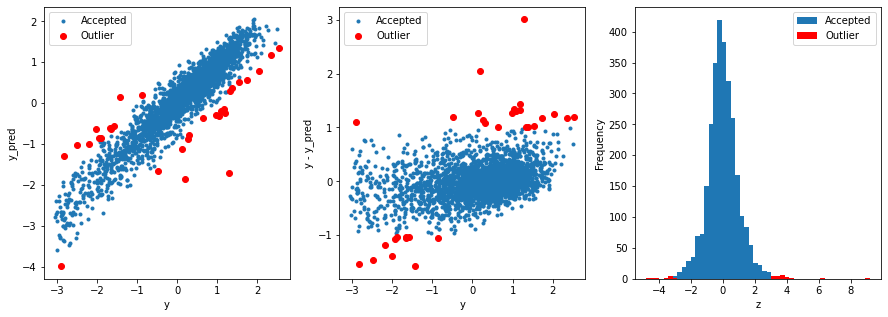

In [9]:
# 通过岭回归模型找出异常值，并绘制其分布
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
X_train = train_data.iloc[:,0:-1]
y_train = train_data.iloc[:,-1]
outliers = find_outliers(Ridge(),X_train,y_train)

#删除指定行 X_train.drop(idnex = outliers)

## 直方图和Q-Q图

Q-Q图是指数据的分位数和正态分布的分位数对比参照的图，如果数据符合正态分布，则所有的点都会落在直线上。首先，通过绘制变量V0的直方图查看其在训练集集中的统计分布，并绘制Q-Q图查看V0的分布是否近似于正态分布

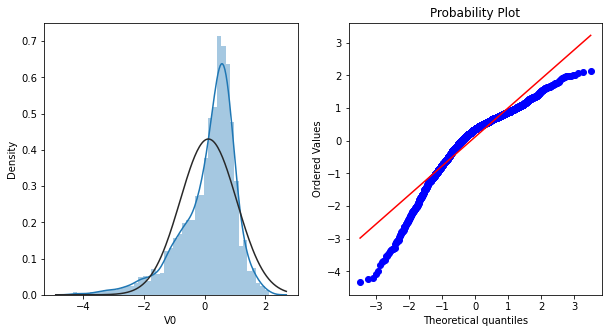

In [11]:
plt.figure(figsize=(10,5))

ax = plt.subplot(1,2,1)
sns.distplot(train_data['V0'],fit=stats.norm)
ax = plt.subplot(1,2,2)
res = stats.probplot(train_data['V0'],plot=plt)

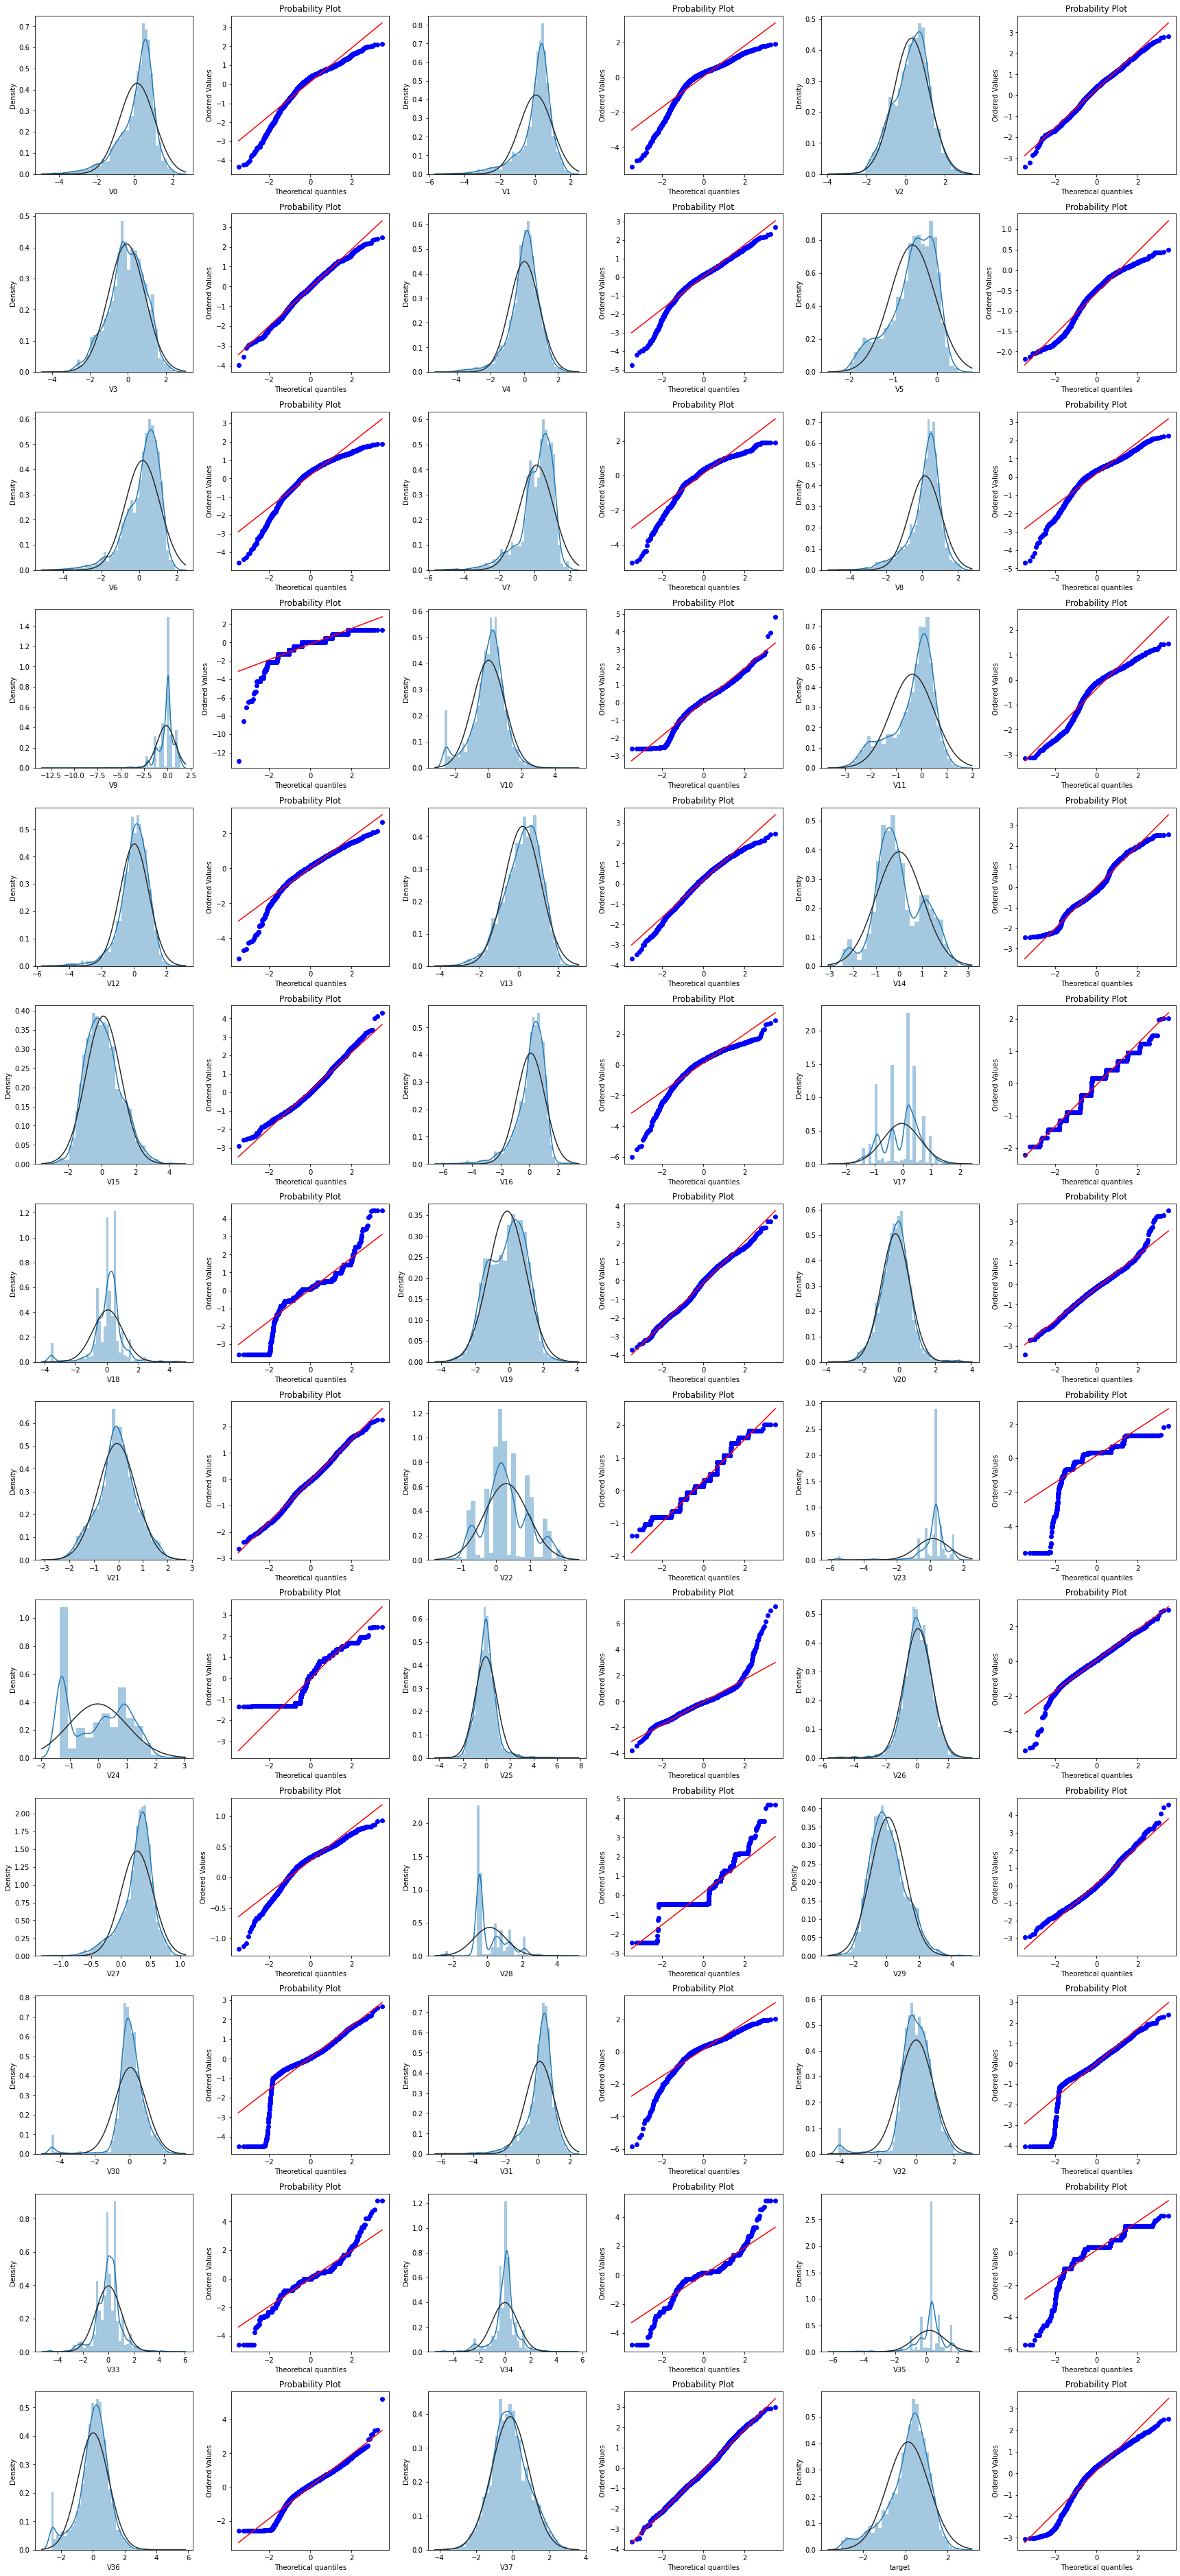

In [14]:
train_cols = 6
train_rows = len(train_data.columns)
#figsize为（宽，高）
plt.figure(figsize=(4*train_cols,4*train_rows))

i = 0
for col in train_data.columns:
    i+=1
    ax = plt.subplot(train_rows,train_cols,i)
    sns.distplot(train_data[col],fit=stats.norm)

    i+=1
    ax = plt.subplot(train_rows,train_cols,i)
    stats.probplot(train_data[col],plot=plt)

# tight_layout会自动调整子图参数，使之填充整个图像区域
plt.tight_layout()
plt.show()

很多特征变量如V1,V9,V24,V28等的数据分布不是正态的，数据并不跟随对角线分布，后续可以使用数据变换对其进行处理

## KDE分布图
KDE核密度估计 可以理解为是对直方图的加窗平滑。通过绘制KDE分布图，可以查看并对比训练集和测试集中特征变量的分布情况，发现两个数据集中分布不一致的特征变量。

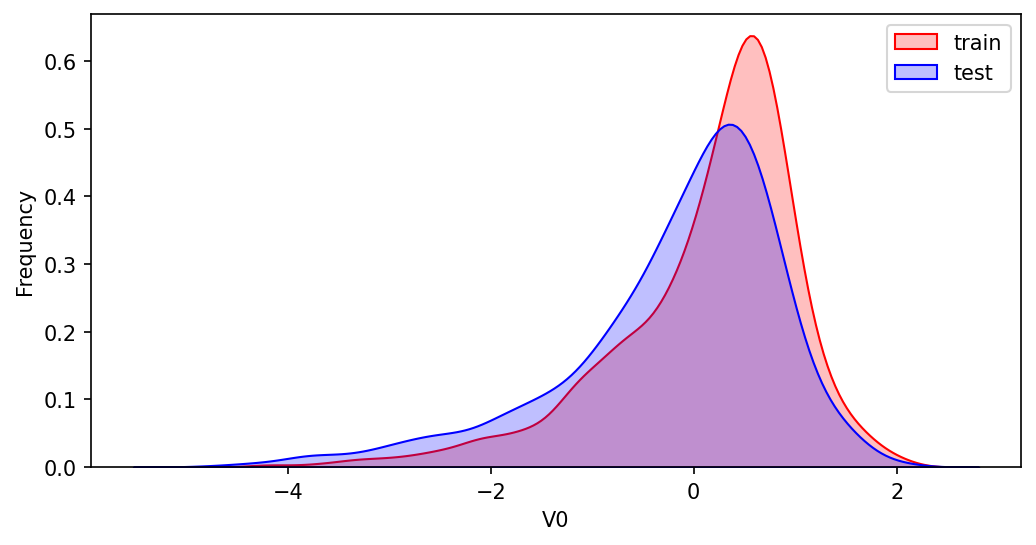

In [17]:
col_name = 'V0'
plt.figure(figsize=(8,4),dpi=150)
ax = sns.kdeplot(train_data[col_name],color='Red',shade=True)
ax = sns.kdeplot(test_data[col_name],color='Blue',shade=True)
ax.set_xlabel(col_name)
ax.set_ylabel('Frequency')
ax = ax.legend(['train','test'])

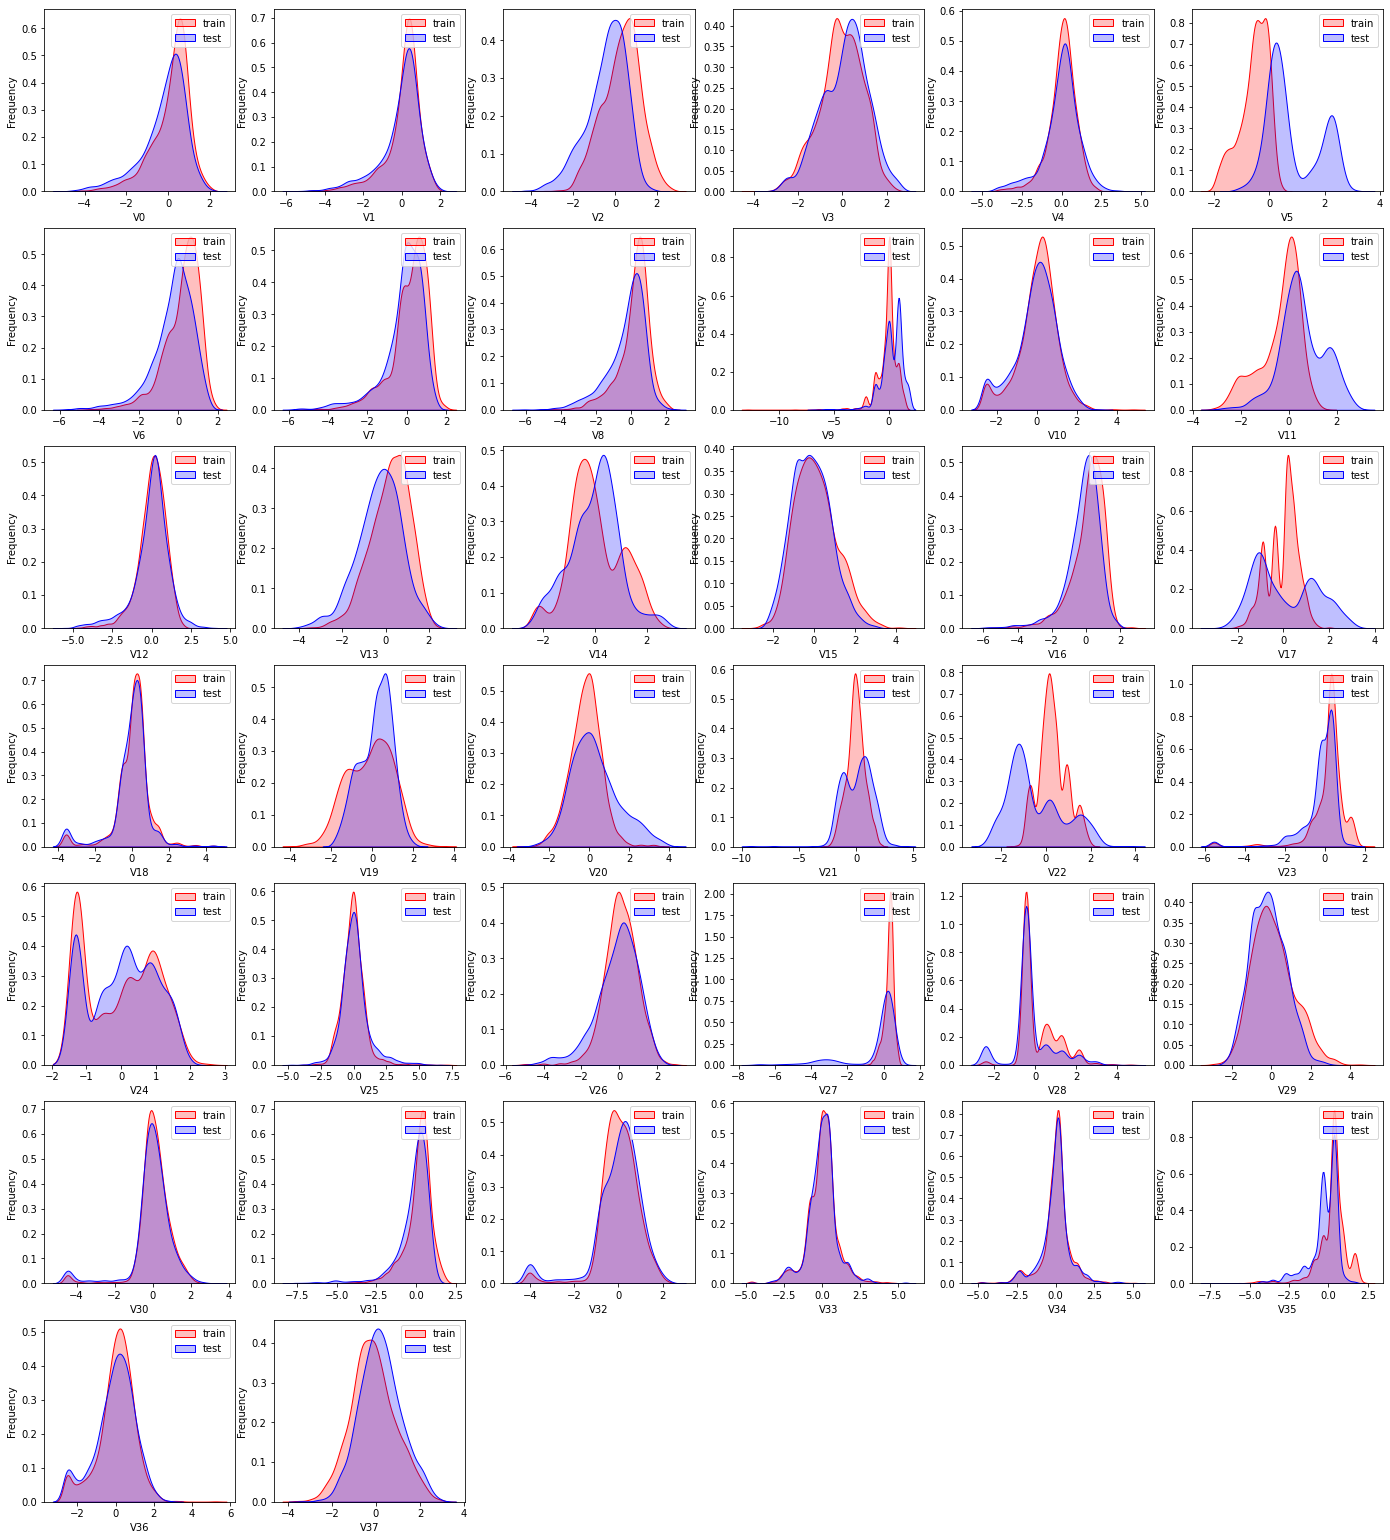

In [29]:
dist_cols = 6
dist_rows = len(test_data.columns)
plt.figure(figsize=(4*dist_cols,4*dist_rows))
i = 1
for col in test_data.columns:
    ax = plt.subplot(dist_rows,dist_cols,i)
    ax = sns.kdeplot(train_data[col],color='Red',shade=True)
    ax = sns.kdeplot(test_data[col],color='Blue',shade=True)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax = ax.legend(['train','test'])
    i+=1
plt.show()

可以发现，特征变量V5 V9 V11 V17 V22 V28在训练集和测试集中的分布不一致，这会导致模型的泛化能力变差，需要删除此类特征

## 线性回归图

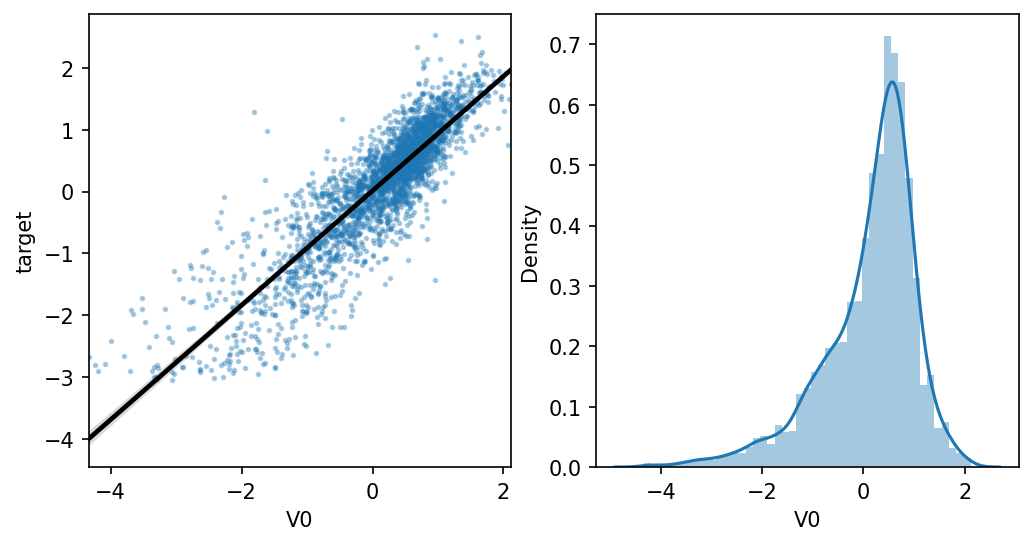

In [30]:
fcols = 2
frows = 1
plt.figure(figsize=(8,4),dpi=150)

ax = plt.subplot(1,2,1)
sns.regplot(x='V0',y='target',data=train_data,ax=ax,
           scatter_kws={'marker':'.','s':3,'alpha':0.3},
           line_kws={'color':'k'});
plt.xlabel('V0')
plt.ylabel('target')

ax = plt.subplot(1,2,2)
sns.distplot(train_data['V0'].dropna())
plt.xlabel('V0')

plt.show()

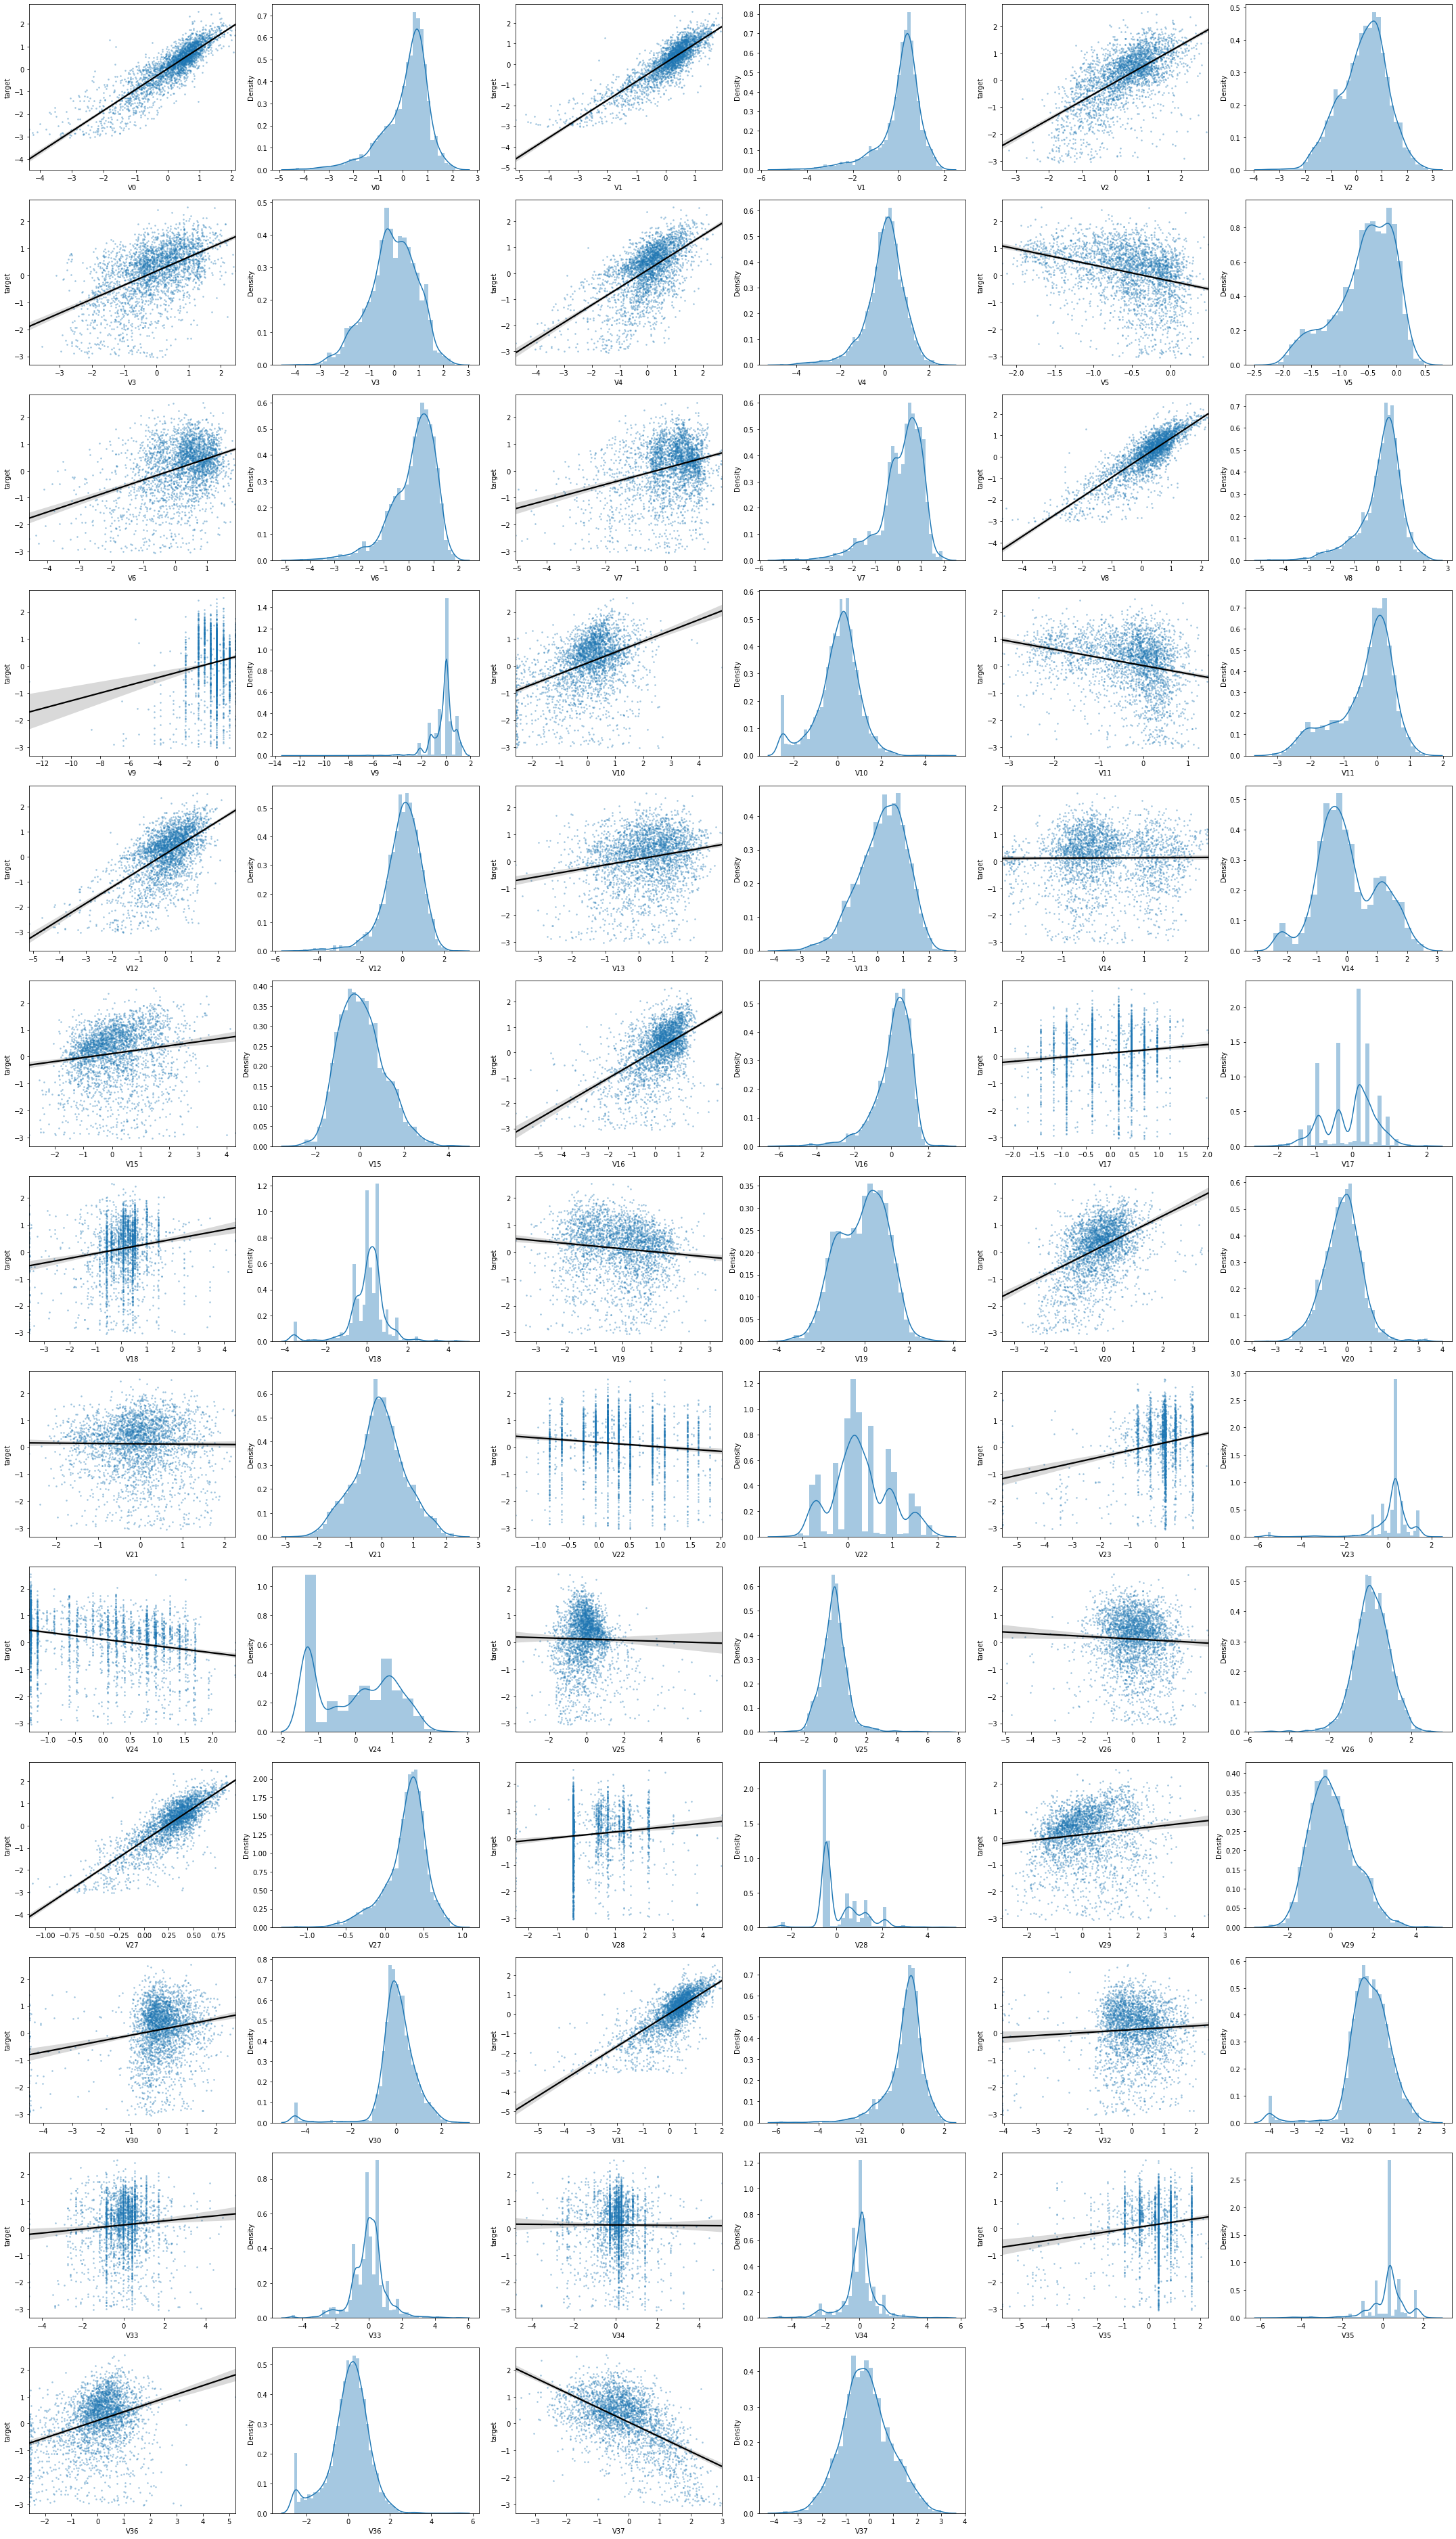

In [42]:
fcols = 6
frows = len(test_data.columns)
plt.figure(figsize=(5*fcols,4*frows))

i = 0
for col in test_data.columns:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.regplot(x=col,y='target',data=train_data,ax=ax,
               scatter_kws={'marker':'.','s':3,'alpha':0.3},
               line_kws={'color':'k'});
    plt.xlabel(col)
    plt.ylabel('target')
    
    i+=1
    ax = plt.subplot(frows,fcols,i)
    
    sns.distplot(train_data[col].dropna())
    plt.xlabel(col)
    
plt.tight_layout()
plt.show()

查看所有特征变量与Target变量的线性回归关系

## 特征变量的相关性

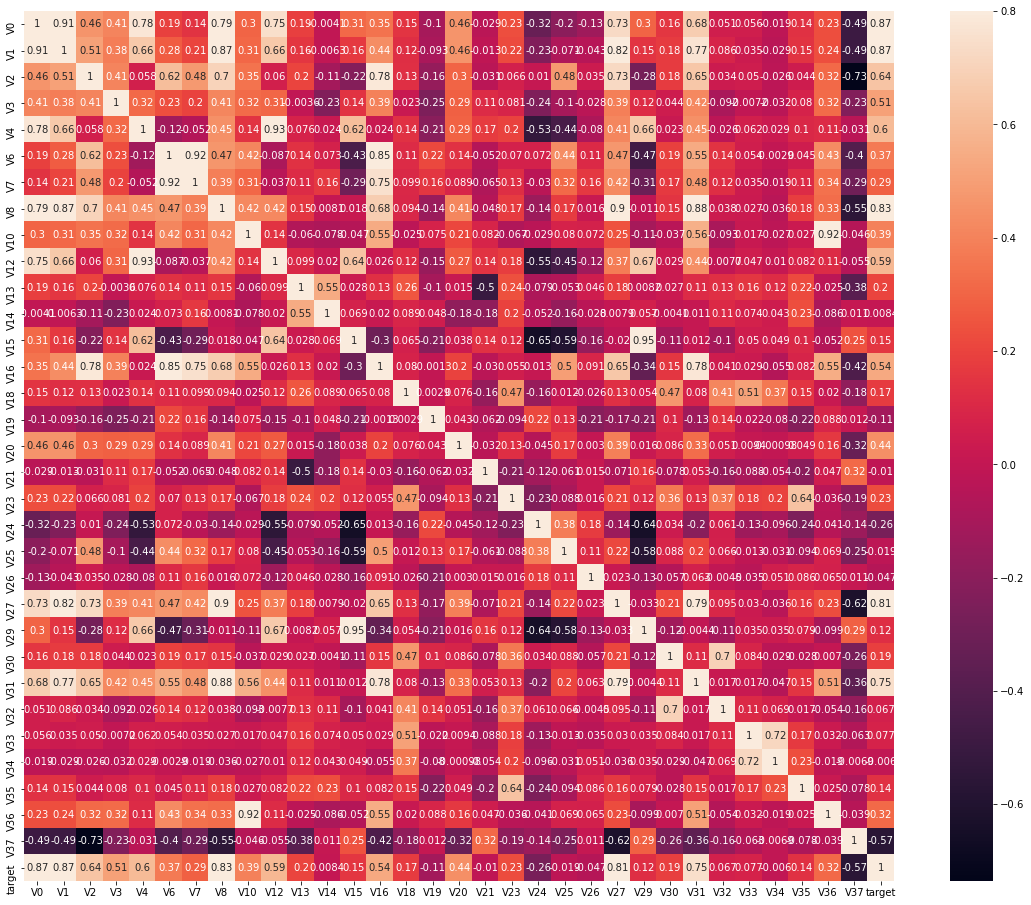

In [18]:
#设置显示最大列数和行数
pd.set_option('display.max_columns',10)
pd.set_option('display.max_rows',10)
data_train1 = train_data.drop(['V5', 'V9', 'V11', 'V17', 'V22', 'V28'],axis=1)
train_corr = data_train1.corr() #计算相关系数

ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(train_corr,vmax=.8,square=True,annot=True)


寻找K个与target变量最相关的特征变量

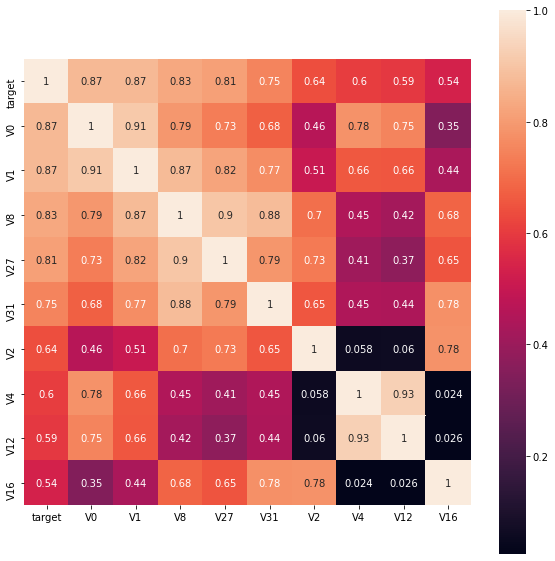

In [22]:
k = 10
cols = train_corr.nlargest(k,'target')['target'].index

cm = np.corrcoef(train_data[cols].values.T)
hm = plt.subplots(figsize=(10,10))
hm = sns.heatmap(train_data[cols].corr(),annot=True,square=True)
plt.show()

找出与target变量的相关系数大于0.5的特征变量

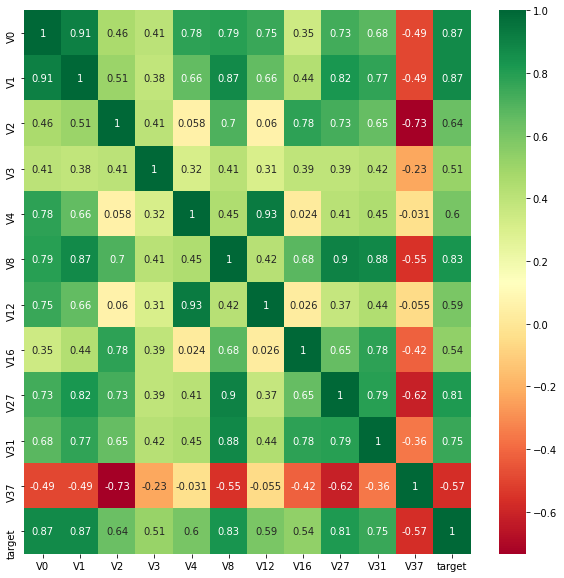

In [48]:
threshold = 0.5

corrmat = train_data.corr()
top_corr_features = corrmat.index[abs(corrmat['target'])>threshold]
plt.figure(figsize=(10,10))
g = sns.heatmap(train_data[top_corr_features].corr(),annot=True,cmap='RdYlGn')

说明：相关性选择主要用于判别线性相关，对于target变量如果存在更复杂的函数形式影响，则建议使用树模型的特征重要性去选择

In [23]:
# 用相关系数阈值移除相关特征
threshold = 0.5

corr_matrix = data_train1.corr().abs()
drop_col = corr_matrix[corr_matrix['target']<threshold].index
# data_all.drop(drop_col,axis=1,inplace=True)

## Box-Cox变换

在连续的响应变量不满足正态分布时，可以使用Box-Cox变换，可使线性回归模型在满足线性、正态性、独立性及方差齐性的同时，又不丢失信息。

在Box-Cox变换后，可以在一定程度上减小不可观测的误差和预测变量的相关性，这有利于线性模型的拟合及分析出特征的相关性。

在Box-Cox变换之前，需要对数据做归一化预处理

In [25]:
#测试数据分布和训练数据分布不一致的列要去除
drop_columns = ['V5', 'V9', 'V11', 'V17', 'V22', 'V28']
# 合并训练集和测试集
train_x = train_data.drop(['target'],axis=1)
train_x['flag'] = 'train'
test_data['flag'] = 'test'

data_all = pd.concat([train_x,test_data],axis=0,ignore_index=True)
data_all.drop(drop_columns,axis=1,inplace=True)

# 归一化
cols_numeric = [i for i in list(data_all.columns) if i!='flag']

def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())

data_all[cols_numeric] = data_all[cols_numeric].apply(scale_minmax,axis=0)

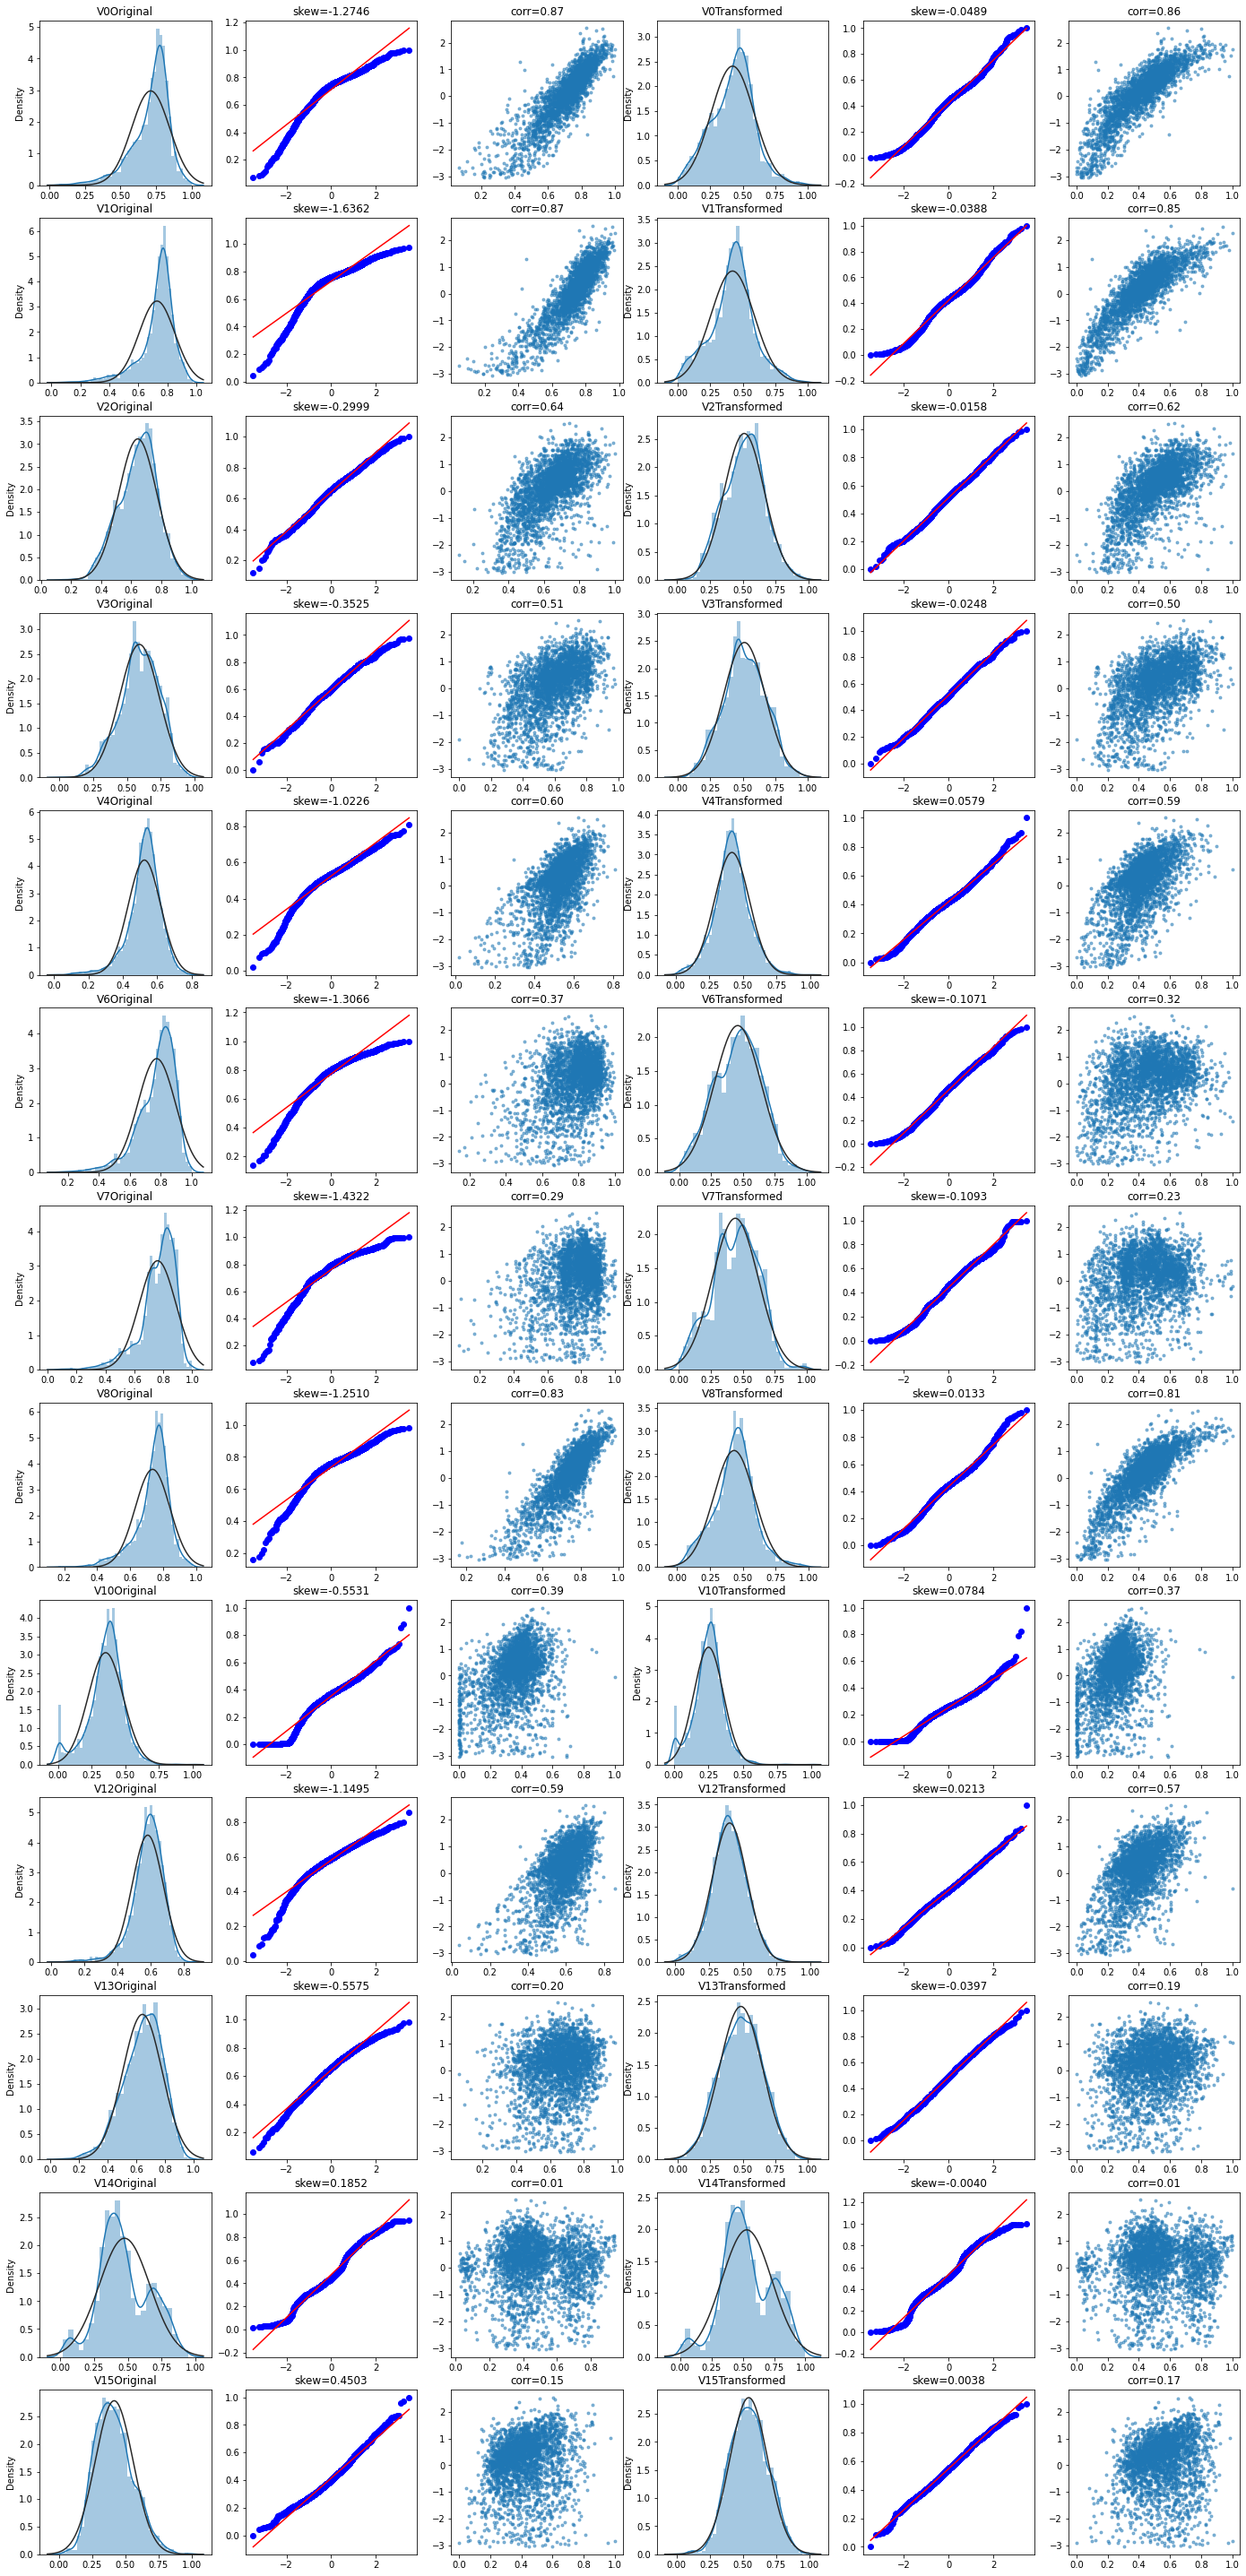

In [62]:
train_data_process = data_all[data_all['flag']=='train']
train_data_process.drop(['flag'],axis=1,inplace=True)

cols_numeric_left = cols_numeric[:13]
cols_numeric_right = cols_numeric[13:]
train_data_process = pd.concat([train_data_process,train_data['target']],axis=1)

fcols = 6
frows = len(cols_numeric_left)
plt.figure(figsize=(4*fcols,4*frows))
i=0

for var in cols_numeric_left:
    dat = train_data_process[[var,'target']].dropna()
    i+=1
    plt.subplot(frows,fcols,i)
    sns.distplot(dat[var],fit=stats.norm)
    plt.title(var+' Original')
    plt.xlabel('')
    i+=1
    plt.subplot(frows,fcols,i)
    _ = stats.probplot(dat[var],plot=plt)
    plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
    plt.xlabel('')
    plt.ylabel('')
    i+=1
    plt.subplot(frows,fcols,i)
    plt.plot(dat[var],dat['target'],'.',alpha=0.5)
    plt.title('corr=' + '{:.2f}'.format(np.corrcoef(dat[var],dat['target'])[0][1]))
    
    i+=1
    plt.subplot(frows,fcols,i)
    trans_var,lambda_var = stats.boxcox(dat[var].dropna()+1)
    trans_var = scale_minmax(trans_var)
    sns.distplot(trans_var,fit=stats.norm)
    plt.title(var + ' Transformed')
    plt.xlabel('')
    i+=1
    plt.subplot(frows,fcols,i)
    _ = stats.probplot(trans_var,plot=plt)
    plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
    plt.xlabel('')
    plt.ylabel('')
    i+=1
    plt.subplot(frows,fcols,i)
    plt.plot(trans_var,dat['target'],'.',alpha=0.5)
    plt.title('corr='+'{:.2f}'.format(np.corrcoef(trans_var,dat['target'])[0][1]))